This code uses JAX to solve an ODE function dy/dt = A * y, and optimize parameter A such that y(t1) equals a target value 20.

It uses adam to update the parameter during training.


In [1]:
!pip install optax


In [2]:
!pip install diffrax


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.3/171.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 2.0 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


Training time: 7.1064372062683105 seconds
Optimized t: 2.9957561
Optimized y(t1): 20.000484
Target y:  20


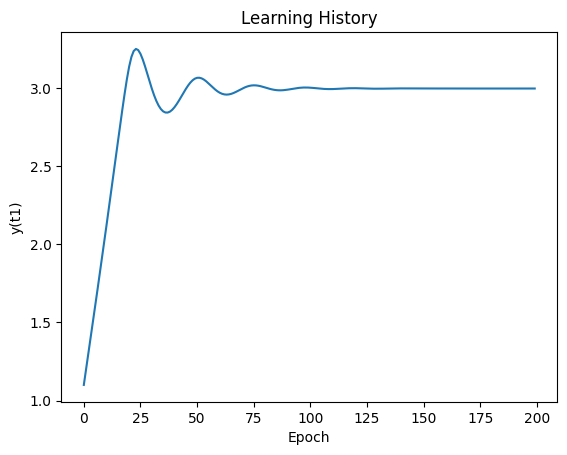

In [4]:
import jax
import jax.numpy as jnp
import diffrax # for numerical solver
import optax # for optimization
from jax import grad
import matplotlib.pyplot as plt
import time

# Define the ODE system dy/dt = A * y, A is a constant
def f(t, y, args):
    param = args[0]
    dydt = param * y
    return dydt

# Define the numerical solver using diffrax
# Solve for y at t1
def solve_ode(param, y0=1.0, t0=0.0, t1=1.0):
    y0 = jnp.array([y0])
    term = diffrax.ODETerm(f)
    solver = diffrax.Tsit5()
    solution = diffrax.diffeqsolve(
        term,
        solver,
        t0=t0,
        t1=t1,
        dt0=0.1,
        y0=y0,
        args=(param,),
    )
    return solution.ys[-1, 0]  # return y(t)

# Optimizaiton objective -- optimize for a target y = 10
def objective(t, target_y):
    y_t1 = solve_ode(t)
    y_target = 20.0 # target y value
    loss = (y_target - y_t1) ** 2 # L2 loss
    return loss

# Initialize the Adam optimizer with optax
learning_rate = 0.1
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(jnp.array([1.0])) # Initial guess for the parameter

# Preallocate an array for storing t history
num_epoch = 200
param_hist = jnp.zeros(num_epoch)
target_y = 20
# Optimization loop
param = jnp.array([1.0])  # Initial t guess
start_time = time.time()
for i in range(num_epoch):
    grads = grad(objective)(param, target_y)
    updates, opt_state = optimizer.update(grads, opt_state)
    param = optax.apply_updates(param, updates)  # Update param
    param_hist = param_hist.at[i].set(param[0])  # Store current param

end_time = time.time()
training_time = end_time - start_time
print("Training time:", training_time, "seconds")

optimized_param = param[0]
optimized_y = solve_ode(optimized_param)

print("Optimized t:", optimized_param)
print("Optimized y(t1):", optimized_y)
print('Target y: ', target_y)
plt.plot(param_hist)
plt.xlabel("Epoch")
plt.ylabel("y(t1)")
plt.title("Learning History")
plt.show()